In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
# import open3d as o3d
import os
# from open3d import JVisualizer

TAG_CHAR = np.array([202021.25], np.float32)

def readFlow(fn):
    with open(fn, 'rb') as f:
        magic = np.fromfile(f, np.float32, count=1)
        if 202021.25 != magic:
            print('Magic number incorrect. Invalid .flo file')
            return None
        else:
            w = np.fromfile(f, np.int32, count=1)
            h = np.fromfile(f, np.int32, count=1)
            data = np.fromfile(f, np.float32, count=2*int(w)*int(h))
            return np.resize(data, (int(h), int(w), 2))

def coords_grid(ht, wd, cnt_x, cnt_y):
    step_x = (wd - 1) // (cnt_x - 1)
    step_y = (ht - 1) // (cnt_y - 1)
    coords = torch.meshgrid(torch.arange(0, ht, step=step_y), torch.arange(0, wd, step=step_x))
    coords = torch.stack(coords[::-1], dim=0).float()
    return coords.permute([1,2,0])


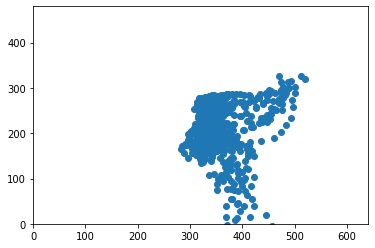

In [10]:
cnt_x = 32
cnt_y = 24
root = '../data/cap/video-4'

points_path = os.path.join(root, 'points')
if not os.path.exists(points_path):
    os.mkdir(points_path)

results_path = os.path.join(root, 'results')
if not os.path.exists(results_path):
    os.mkdir(results_path)

flow_list = sorted(os.listdir(os.path.join(root, 'flows')))
for flow_name in flow_list:
    flow = readFlow(os.path.join(root, 'flows', flow_name))
    H, W = flow.shape[:2]
    coord1 = coords_grid(H, W, cnt_x, cnt_y)
    coord1_h = coord1.reshape(-1,2).numpy().astype(np.uint)
    coord2 = flow[coord1_h[:,1], coord1_h[:,0]] + coord1_h

    data = np.concatenate([coord1_h, coord2], axis=1)
    np.savetxt(os.path.join(points_path, '{:s}.txt'.format(flow_name.split('.')[0])), data)

plt.scatter(coord2[:,0], coord2[:,1])      # x 代表x轴 y 代表y轴数据, 数据维度必须相同
plt.xlim([0,640])
plt.ylim([0,480])
plt.show()

In [42]:
# result = np.loadtxt('../data/results.txt')

# points3d = result[:, :3]
# colors = result[:, 3:] / 255

# pcd = o3d.geometry.PointCloud()
# pcd.points = o3d.utility.Vector3dVector(points3d)
# pcd.colors = o3d.utility.Vector3dVector(colors)


visualizer = JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()

JVisualizer with 1 geometries

In [13]:
files = sorted(os.listdir(os.path.join(root, 'flows')))
files = [line[:6] for line in files]
np.savetxt(os.path.join(root, 'index.txt'), files, fmt='%s')